Created by Marina Dunn, Spring 2022

**Resources used:**

https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2

https://github.com/deepskies/deepmerge-public/blob/master/DeepMerge-noisy.ipynb

https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939

https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e

https://www.superdatascience.com/blogs/convolutional-neural-networks-cnn-softmax-crossentropy

In [ ]:
# system level
import os
import codecs
import sys
import json
import h5py
import numpy as np
from numpy import random
from scipy import interp
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
from __future__ import print_function
import time
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# machine learning
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import BatchNormalization, Input, Flatten, RandomFlip, Dense
from tensorflow.keras.layers import RandomRotation, Activation, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import VGG16
#from keras.utils import np_utils
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, brier_score_loss
from sklearn.model_selection import cross_val_score, KFold

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'
import matplotlib
%matplotlib inline

In [21]:
tf.config.run_functions_eagerly(True)

### Load and define data

In [6]:
# Load year 1 train, test, validation image files
X_train_1 = np.load('images_Y1_train.npy')
X_test_1 = np.load('images_Y1_test.npy')
X_valid_1 = np.load('images_Y1_valid.npy')

In [7]:
# Load year 10 train, test, validation image files
X_train_10 = np.load('images_Y10_train.npy')
X_test_10 = np.load('images_Y10_test.npy')
X_valid_10 = np.load('images_Y10_valid.npy')

In [8]:
# Load year 1 and 10, label small subset test files
X_test_1_sub = np.load('images_Y1_test_150.npy')
X_test_10_sub = np.load('images_Y10_test_150.npy')
Y_test_sub = np.load('labels_test_150.npy')

In [9]:
# Load image label files
Y_train = np.load('labels_train.npy')
Y_test = np.load('labels_test.npy')
Y_valid = np.load('labels_valid.npy')

In [10]:
# define full datasets by combining train + test + validation sets
X_1_data = np.concatenate([X_train_1, X_test_1, X_valid_1], axis=0)
np.shape(X_1_data)

(33557, 3, 100, 100)

In [11]:
X_10_data = np.concatenate([X_train_10, X_test_10, X_valid_10], axis=0)
np.shape(X_10_data)

(33557, 3, 100, 100)

In [12]:
Y_data = np.concatenate([Y_train, Y_test, Y_valid], axis=0)
np.shape(Y_data)

(33557, 3)

**Choosing batch size, epoch:**

batch size: larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster. 
epoch: models improve with more epochs of training, to a point; will start to plateau in accuracy as they converge. 

In [13]:
# training variables for model 1
# 70:10:20 for training:valid:test
NUM_TRAIN = 23487 # num train images
NUM_TEST = 6715 # num test images
NUM_VALIDATION = 3355 # num validation images
shuffle = True
NUM_EPOCH = 100
batch_size = 128

In [14]:
# Shuffle data
random.seed(5)
idx = np.random.choice(len(X_1_data), size=len(X_1_data), replace=False)
X_1_data = X_1_data[idx]
X_10_data = X_10_data[idx]
Y_data = Y_data[idx]

In [13]:
# check data sizes
NUM_TOTAL = NUM_TRAIN + NUM_TEST + NUM_VALIDATION
print(NUM_TOTAL)
assert NUM_TOTAL == len(X_train_1) + len(X_test_1) + len(X_valid_1), "total training, test, validation samples not equal to total samples - exiting"


33557


### Exploratory Data Analysis

In [14]:
# Y_train_df = pd.DataFrame(Y_train)
# Y_test_df = pd.DataFrame(Y_test)
# Y_valid_df = pd.DataFrame(Y_valid)

In [15]:
#Y_train_df.info()
#Y_test_df.info()
#Y_valid_df.info()

In [16]:
#Y_train_df.value_counts()
#Y_test_df.value_counts()
#Y_valid_df.value_counts()

In [17]:
#Y_train_df.describe()
#Y_test_df.describe()
#Y_valid_df.describe()

Each image represents a series of pixels in a grid-like format with a value of brightness for each pixel.

In [12]:
print( "Data dimensions: ")
# training on year 1
print( "Input data: ", np.shape(X_1_data), np.shape(Y_data)) # same for year 10
print( "Training Set: ", np.shape(X_train_1), np.shape(Y_train)) # same for year 10
print( "Test Set: ", np.shape(X_test_1), np.shape(Y_test)) # same for year 10
print( "Validation Set: ", np.shape(X_valid_1), np.shape(Y_valid)) # same for year 10

Data dimensions: 
Input data:  (33557, 3, 100, 100) (33557, 3)
Training Set:  (23487, 3, 100, 100) (23487, 3)
Test Set:  (6715, 3, 100, 100) (6715, 3)
Validation Set:  (3355, 3, 100, 100) (3355, 3)


In [13]:
print("Subset Test Set: ", np.shape(X_test_1_sub))

Subset Test Set:  (150, 3, 100, 100)


```
Multi-Class Classification
3 columns: spiral (or '0'), elliptical ('1'), or a galaxy merger ('2’) - (num_classes – 1)
No null values, min:0, max:1
dtype: int64

(year 1)
Training set details:
• 23487 total images
• 10017 Spiral galaxies (mean: 0.426491, std: 0.494577)
• 5705 Elliptical galaxies (mean: 0.242900, std: 0.428844)
• 7765 Merger galaxies (mean: 0.330608, std: 0.470442)
• Memory usage: 550.6 KB

Test set details:
• 6715 total images
• 2863 Spiral galaxies (mean: 0.426359, std: 0.494584)
• 1631 Elliptical galaxies (mean: 0.242889, std: 0.428861)
• 2221 Merger galaxies (mean: 0.330752, std: 0.470519)
• Memory usage: 157.5 KB

Validation set details:
• 3355 total images
• 1432 Spiral galaxies (mean: 0.426826, std: 0.494690)
• 815 Elliptical galaxies (mean: 0.242921, std: 0.428912)
• 1108 Merger galaxies (mean: 0.330253, std: 0.470374)
• Memory usage: 78.8 KB
```

In [15]:
# cast data types as floats
X_train_1 = X_train_1.astype('float32')
X_test_1 = X_test_1.astype('float32')
X_valid_1 = X_valid_1.astype('float32')

X_train_10 = X_train_10.astype('float32')
X_test_10 = X_test_10.astype('float32')
X_valid_10 = X_valid_10.astype('float32')

X_test_1_sub = X_test_1_sub.astype('float32')
X_test_10_sub = X_test_10_sub.astype('float32')

# Build deterministic CNN model:
First build a standard deterministic CNN classifier model as a baseline model. CNN/ConvNet typically uses ~3 convolution layers: a convolutional layer, a pooling layer, and a fully connected layer. The layer setup is such that simpler patterns are recognized first, then increasingly complex patterns thereafter.

Perform series of convolution + pooling operations, then a number of fully connected layers. 

**Convolutional Layer:** Contains most of the network's main computational load. Performs dot product between kernel (matrix 1) and restricted portion of the receptive field (matrix 2). Forward pass. Creates an activation/feature map, or 2D representation of the image.

**Pooling Layer:** provides summary statistic of nearby outputs at various network output locations. Pooling operation performed individually on every slice of activation map. Max pooling is most popular.

**Fully Connected Layer:** helps map the representation b/w input and the output. Matrix multiplication, followed by a bias effect. Helps to learn non-linear combinations of features.

#### Steps:

1) Train

2) Validate on a holdout set generated from the original training data

3) Evaluate on the test data

In [15]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.8.0
Tensorflow Probability Version:  0.16.0


#### Defining CNN model architecture:

##### Activation functions:

**-Sigmoid:** σ(κ) = 1/(1+e¯κ), takes real-value number & “squashes” into a range 0-1

**-ReLU/'relu':** Rectified Linear Unit, calculates ƒ(κ)=max (0,κ), or the activation is simply threshold at 0. More reliable + faster than sigmoid, tanh. More non-linearity gives more power to the model

**-Softmax/Normalized Exponential:** converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector.

##### Keras layers:

**Convolution2D():** 2D convolution layer (e.g. spatial convolution over images). 

-args: activation (activation function to use), 

**MaxPooling2D():** Max pooling operation for 2D spatial data

-args: pool_size (window size over which to take the maximum), strides (Specifies how far the pooling window moves for each pooling step; sliding size of the kernel), padding (''valid"- no padding, or ''same"- padding evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input), data_format (ordering of the dimensions in the inputs)

data_format='channels_first': 

input: 4D tensor with shape (batch_size, channels, rows, cols)
output: 4D tensor with shape (batch_size, channels, pooled_rows, pooled_cols).

**Dense():** regular densely-connected neural network layer (describes a layer of neurons)

-args: activation (activation function to use), kernel_regularizer (regularizer function applied to the kernel weights matrix)

##### Regularization
**Dropout:** Most popular regularization technique, prevents overfitting. At each iteration, neuron temporarily “dropped” with probability 'p'. This neuron is resampled with 'p' at every training step, so will be active at next step. Typically ~0.5 or 50%. Can be applied to input or hidden layer nodes, but not output nodes. 

**Batch Normalization:** explicitly forces the activations throughout a network to take on a Gaussian distribution at the beginning of training, applying a transformation that maintains mean output close to 0 and output standard deviation close to 1. BatchNorm layer inserted immediately after fully connected layers, or convolutional layers, and before non-linearities. Significantly more robust to bad initialization.

##### Keras Early stopping
**Early stopping:** Early stopping call back function can be used to monitor either accuracy or loss, stopping when there's either a loss increment, or accuracy decrement. Should monitor the thing that is more sensitive, which is usually loss function- will start seeing signs of overfitting in loss earlier. 

##### Keras Optimizers:  
**Adam:** implements the Adam algorithm; learning rate of 0.001. Stochastic gradient descent method based on adaptive estimation of 1st-order and 2nd-order moments. Very performant.

##### Loss function: 
**Categorical Cross-entropy:** Computes the cross-entropy loss between the labels and predictions. Used when adjusting model weights during training. Categorical cross-entropy is used with 'softmax' activation for multi-class classification problem, i.e. when true label values are one-hot encoded for 3-class classification problem.

**Sparse Categorical Cross-entropy:** Same as above, but does not require one-hot encoding. Used when there are many labels.

##### Additional techniques to potentially look at:
**Cross validation:** (i.e. k-fold), partition the original training data set into k equal subsets, each called a fold (named f1, f2, …, fk, for i = 1 to i = k). Keep the fold fi as the Validation set, and keep all the remaining k-1 folds in the Cross validation training set. Train model using the cross validation training set; calculate accuracy by validating predicted results against the validation set. Estimate accuracy of model by averaging the accuracies derived in all the k cases of cross validation. Helps reduce overfitting problem.

In [16]:
class_names = ['Spiral', 'Elliptical', 'Merger']
NUM_CLASSES = len(class_names)
print(class_names)

['Spiral', 'Elliptical', 'Merger']


In [3]:
base_dir = '/Users/marinadunn/Desktop/Grad_School/Research/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

f_model = base_dir + "model.json" # model data (architecture)
f_history = base_dir + "history.json" # training history 
f_weights = base_dir + "weights.h5" # model data (final weights)
f_best_weights = base_dir + "best_weights.h5" # model data (best weights, give highest validation accuracy)

### Model 1

In [33]:
# Defining model layers, build with the Functional API
data_shape = np.shape(X_1_data)
#(channels, rows, cols)
input_shape = (3, 100, 100)

# Constraints for layer 1
# input: tensors of shape (color_channels, image_height, image_width), ignoring batch size
x = Input(shape=input_shape)
#For CNN: Convolution typically uses 3x3 windows, stride 1 & with padding. Will try 5x5 window first to attempt tp catch more features, but try multiple
c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
b0 = BatchNormalization()(c0)
#For CNN: pooling typically uses 2x2 windows, stride 2 & no padding
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.5)(d0)

# Constraints for layer 2
c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.5)(d1)

# Constraints for layer 3
c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.5)(d2)

#flatten (or unroll) the 3D output to 1D
f = Flatten()(e2)

# hidden layer
# Dense layer: takes 1D vector as input, current output is a 3D tensor; start simple, then change unit to try to increase performance
z0 = Dense(512, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(256, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
# use L2 regulization: take sum of all params squared & add it w/ square difference of actual output & predictions
# weights not sparse, will get much better accuracy than L1
z2 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_3')(z1)
z3 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_4')(z2)
# output layer must create 3 output values, one for each class
# use “softmax” activation function to ensure output values are in range 0-1 & may be used as predicted probabilities
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z3)

model = Model(inputs=x, outputs=y)

Metal device set to: Apple M1


2022-05-09 11:59:41.385733: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-09 11:59:41.386740: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [34]:
# Compile Model
optimizer = 'adam'
metrics = ['accuracy']
# Multi-Class Cross-Entropy Loss
loss = 'categorical_crossentropy' 
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization (BatchN  (None, 8, 100, 100)      400       
 ormalization)                                                   
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout (Dropout)           (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                             

In [38]:
"""
monitor: value to be monitored by the function: validation loss or validation accuracy
mode: mode in which change in the quantity monitored should be observed: ‘min’, ‘max’, or ‘auto’. 
For loss, value is ‘min’. For accuracy, value is ‘max’. ‘auto’: monitors with auto suitable mode
patience: number of epochs for the training to be continued after the first halt for any improvement in the model
verbose: integer value- 0, 1 or 2, selects the way in which progress is displayed while training
Verbose = 1: A bar depicting the progress of training is displayed
"""

es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50),
# Save best weights in order to maximize validation accuracy, only saves when the model is considered the "best"
     ModelCheckpoint(filepath=f_best_weights, monitor='val_acc', mode='max', verbose=1, save_best_only=True)] 

In [39]:
# Train Model

history = model.fit(
                    X_train_1, Y_train,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,
                    validation_data=(X_valid_1, Y_valid),                
                    shuffle=shuffle,
                    verbose=True,
                    callbacks=es
            )

Epoch 1/100
184/184 [==============================] - 85s 461ms/step - loss: 1.0381 - accuracy: 0.5472 - val_loss: 1.2359 - val_accuracy: 0.4134
Epoch 2/100
184/184 [==============================] - 85s 461ms/step - loss: 0.9983 - accuracy: 0.5686 - val_loss: 1.1827 - val_accuracy: 0.4304
Epoch 3/100
184/184 [==============================] - 85s 462ms/step - loss: 0.9645 - accuracy: 0.5814 - val_loss: 1.0724 - val_accuracy: 0.5151
Epoch 4/100
184/184 [==============================] - 84s 459ms/step - loss: 0.9274 - accuracy: 0.6077 - val_loss: 1.1474 - val_accuracy: 0.4545
Epoch 5/100
184/184 [==============================] - 85s 462ms/step - loss: 0.8913 - accuracy: 0.6257 - val_loss: 1.0126 - val_accuracy: 0.5446
Epoch 6/100
184/184 [==============================] - 84s 459ms/step - loss: 0.8746 - accuracy: 0.6404 - val_loss: 0.9977 - val_accuracy: 0.5639
Epoch 7/100
184/184 [==============================] - 84s 458ms/step - loss: 0.8493 - accuracy: 0.6555 - val_loss: 0.8976 -

184/184 [==============================] - 83s 453ms/step - loss: 0.6327 - accuracy: 0.8443 - val_loss: 0.9160 - val_accuracy: 0.7714
Epoch 28/100
184/184 [==============================] - 84s 458ms/step - loss: 0.6286 - accuracy: 0.8507 - val_loss: 0.9730 - val_accuracy: 0.7458
Epoch 29/100
184/184 [==============================] - 84s 459ms/step - loss: 0.6151 - accuracy: 0.8577 - val_loss: 0.9290 - val_accuracy: 0.7744
Epoch 30/100
184/184 [==============================] - 84s 457ms/step - loss: 0.6092 - accuracy: 0.8646 - val_loss: 0.9200 - val_accuracy: 0.7809
Epoch 31/100
184/184 [==============================] - 84s 458ms/step - loss: 0.6075 - accuracy: 0.8664 - val_loss: 0.9539 - val_accuracy: 0.7836
Epoch 32/100
184/184 [==============================] - 85s 460ms/step - loss: 0.5944 - accuracy: 0.8726 - val_loss: 0.9478 - val_accuracy: 0.7917
Epoch 33/100
184/184 [==============================] - 85s 459ms/step - loss: 0.5869 - accuracy: 0.8791 - val_loss: 0.9540 - val_a

184/184 [==============================] - 84s 458ms/step - loss: 0.4990 - accuracy: 0.9286 - val_loss: 0.9552 - val_accuracy: 0.8095
Epoch 55/100
184/184 [==============================] - 85s 460ms/step - loss: 0.4924 - accuracy: 0.9327 - val_loss: 0.9462 - val_accuracy: 0.8185
Epoch 56/100
184/184 [==============================] - 84s 458ms/step - loss: 0.4925 - accuracy: 0.9323 - val_loss: 0.9701 - val_accuracy: 0.8122
Epoch 57/100
184/184 [==============================] - 84s 457ms/step - loss: 0.4905 - accuracy: 0.9340 - val_loss: 0.9322 - val_accuracy: 0.8122
Epoch 58/100
184/184 [==============================] - 84s 459ms/step - loss: 0.4851 - accuracy: 0.9359 - val_loss: 0.9763 - val_accuracy: 0.8143
Epoch 59/100
184/184 [==============================] - 84s 459ms/step - loss: 0.4913 - accuracy: 0.9332 - val_loss: 0.9616 - val_accuracy: 0.8125
Epoch 60/100
184/184 [==============================] - 84s 459ms/step - loss: 0.4912 - accuracy: 0.9349 - val_loss: 0.9484 - val_a

In [40]:
# Save data
model.save_weights(f_weights, overwrite=True)
open(f_model, 'w').write(model.to_json())

#Saving history for future use
with open(f_history, 'w') as f:
    json.dump(history.history, f)

In [43]:
#loading history
path = f_history
if os.path.exists(path): # reload history if it exists
        with codecs.open(path, 'r', encoding='utf-8') as f:
             n = json.loads(f.read())
                
#loading model
json_file = open(f_model, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)


# load best weights into new model
loaded_model.load_weights(f_weights)
print("Loaded model from disk")

Loaded model from disk


In [44]:
# Evaluate the model on test data
loaded_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
score = loaded_model.evaluate(X_test_1, Y_test, verbose=True)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

210/210 [==============================] - 5s 25ms/step - loss: 0.9943 - accuracy: 0.8158
accuracy: 81.58%


In [45]:
# Evaluate the model on test smaller subset
score = loaded_model.evaluate(X_test_1_sub, Y_test_sub, verbose=True)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

5/5 [==============================] - 0s 35ms/step - loss: 0.8892 - accuracy: 0.8333
accuracy: 83.33%


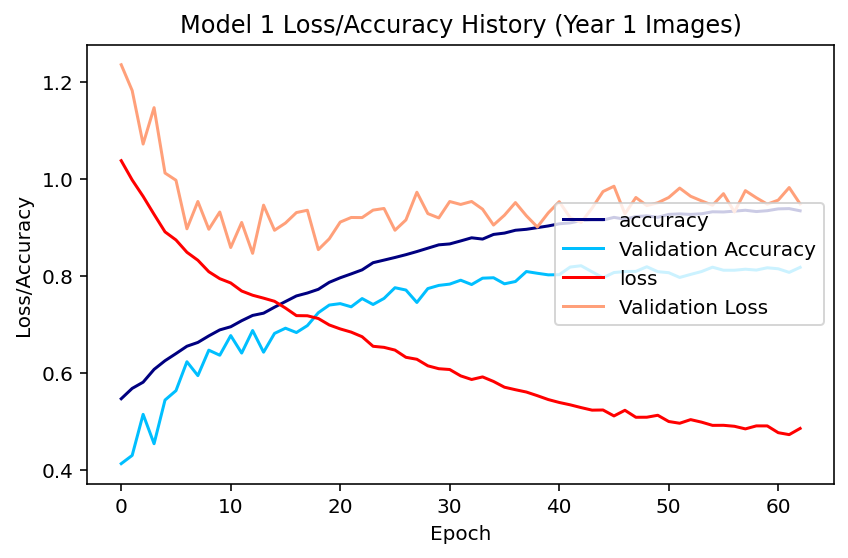

In [46]:
# Visualize training results (Loss)

# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = list(range(len(loss)))

#plot
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="Validation Accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="Validation Loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]

axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Model 1 Loss/Accuracy History (Year 1 Images)")
plt.tight_layout()
axis1.legend(loc='center right')

In [51]:
# Evaluate for test set
# predict
prob = loaded_model.predict(X_test_1)
pred = np.round(prob, 0).astype('int32')

In [57]:
# Classification report
from pprint import pprint
classification_metrics = classification_report(Y_test, pred, target_names=class_names)
pprint(classification_metrics)

('              precision    recall  f1-score   support\n'
 '\n'
 '      Spiral       0.86      0.88      0.87      2863\n'
 '  Elliptical       0.80      0.73      0.76      1631\n'
 '      Merger       0.78      0.78      0.78      2221\n'
 '\n'
 '   micro avg       0.82      0.81      0.82      6715\n'
 '   macro avg       0.82      0.80      0.81      6715\n'
 'weighted avg       0.82      0.81      0.82      6715\n'
 ' samples avg       0.81      0.81      0.81      6715\n')


In [59]:
categorical_test_labels = pd.DataFrame(Y_test).idxmax(axis=1)
categorical_preds = pd.DataFrame(pred).idxmax(axis=1)
confusion_matrix = confusion_matrix(categorical_test_labels, categorical_preds)

def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

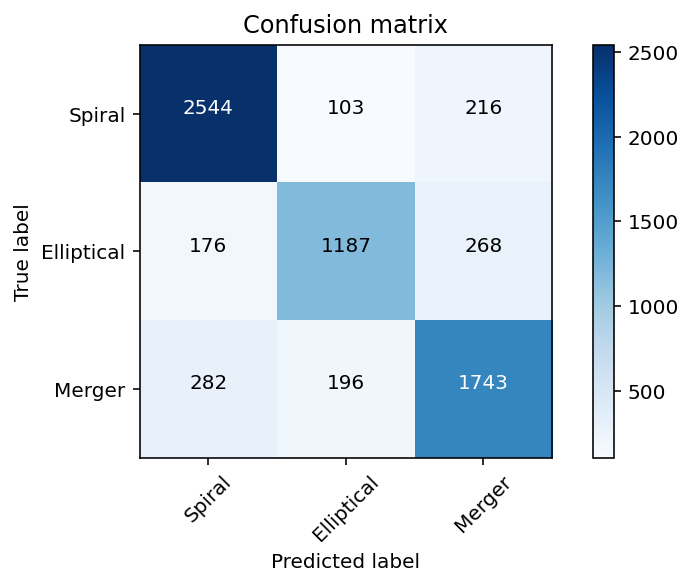

In [62]:
import itertools
plot_confusion_matrix(confusion_matrix, class_names)

In [74]:
labels = [0, 1, 2]
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred, labels=labels, average='samples')
print('Precision (samples): %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(Y_test, pred, labels=labels, average='samples')
print('Recall (samples): %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, pred, labels=labels, average='samples')
print('F1 score (samples): %f' % f1)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred, labels=labels, average='micro')
print('Precision (micro): %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(Y_test, pred, labels=labels, average='micro')
print('Recall (micro): %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, pred, labels=labels, average='micro')
print('F1 score (micro): %f' % f1)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred, labels=labels, average='weighted')
print('Precision (weighted): %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(Y_test, pred, labels=labels, average='weighted')
print('Recall (weighted): %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, pred, labels=labels, average='weighted')
print('F1 score (weighted): %f' % f1)

Accuracy: 0.811914
Precision (samples): 0.811914
Recall (samples): 0.811914
F1 score (samples): 0.811914
Precision (micro): 0.821951
Recall (micro): 0.811914
F1 score (micro): 0.816901
Precision (weighted): 0.821131
Recall (weighted): 0.811914
F1 score (weighted): 0.816085


### Model 2

In [17]:
NUM_EPOCH = 100
batch_size = 16

In [18]:
# Try 2:
# Increased the number of Conv2D layers
# Increased number of filters to try and learn more features
# Added more Dense layers
# Decrease batch size to 32

data_shape = np.shape(X_1_data)
input_shape = (3, 100, 100)

# Constraints for layer 1
x = Input(shape=input_shape)
c0 = Conv2D(64, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.5)(d0)

# Constraints for layer 2
c1 = Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.5)(d1)

# Constraints for layer 3
c2 = Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.5)(d2)

# Constraints for layer 4
c3 = Conv2D(512, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_4')(e2)
b3 = BatchNormalization()(c3)
d3 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_4')(b3)
e3 = Dropout(0.5)(d3)

# Constraints for layer 5
c4 = Conv2D(512, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_5')(e3)
b4 = BatchNormalization()(c4)
d4 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_5')(b4)
e4 = Dropout(0.5)(d4)

# flatten (or unroll) the 3D output to 1D
f = Flatten()(e4)

# hidden layer
z0 = Dense(512, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(256, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
z2 = Dense(128, activation='relu', kernel_regularizer=l2(0.0001), name='dense_3')(z1)
z3 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_4')(z2)
z4 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_5')(z3)
z5 = Dense(16, activation='relu', kernel_regularizer=l2(0.0001), name='dense_6')(z4)
z6 = Dense(8, activation='relu', kernel_regularizer=l2(0.0001), name='dense_7')(z5)
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z6)

model2 = Model(inputs=x, outputs=y)

Metal device set to: Apple M1


2022-05-09 14:01:42.438041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-09 14:01:42.439585: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
# Compile Model
optimizer = 'adam'
metrics = ['accuracy']
loss = 'categorical_crossentropy' 
model2.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 64, 100, 100)      4864      
                                                                 
 batch_normalization (BatchN  (None, 64, 100, 100)     400       
 ormalization)                                                   
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 64, 50, 50)        0         
                                                                 
 dropout (Dropout)           (None, 64, 50, 50)        0         
                                                                 
 conv_2 (Conv2D)             (None, 128, 50, 50)       73856     
                                                             

In [20]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50),
# Save best weights in order to maximize validation accuracy, only saves when the model is considered the "best"
     ModelCheckpoint(filepath=base_dir + "best_weights.h5", monitor='val_acc', mode='max', verbose=1, save_best_only=True)] 

In [ ]:
# Train Model

history = model2.fit(
                    X_train_1, Y_train,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,
                    validation_data=(X_valid_1, Y_valid),                
                    shuffle=shuffle,
                    verbose=True,
                    callbacks=es
            )

Epoch 1/100


2022-05-09 14:18:01.648301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1468/1468 [==============================] - 297s 201ms/step - loss: 1.1130 - accuracy: 0.5029 - val_loss: 1.0248 - val_accuracy: 0.5437
Epoch 2/100
1468/1468 [==============================] - 292s 199ms/step - loss: 0.9870 - accuracy: 0.5426 - val_loss: 0.9596 - val_accuracy: 0.5756
Epoch 3/100
1468/1468 [==============================] - 295s 201ms/step - loss: 0.9177 - accuracy: 0.5724 - val_loss: 0.8916 - val_accuracy: 0.5860
Epoch 4/100
1468/1468 [==============================] - 297s 202ms/step - loss: 0.8808 - accuracy: 0.5903 - val_loss: 0.8768 - val_accuracy: 0.6003
Epoch 5/100
 598/1468 [===========>..................] - ETA: 2:50 - loss: 0.8524 - accuracy: 0.6057

In [ ]:
# Evaluate the model on test data
score = model2.evaluate(X_test_1, Y_test, verbose=True)
print("%s: %.2f%%" % (model2.metrics_names[1], score[1]*100))

In [ ]:
# Evaluate the model on test smaller subset
score = model2.evaluate(X_test_1_sub, Y_test_sub, verbose=True)
print("%s: %.2f%%" % (model2.metrics_names[1], score[1]*100))

In [ ]:
# Evaluate for test set
# predict
prob = loaded_model.predict(X_test_1)
pred = np.round(prob, 0).astype('int32')

In [ ]:
labels = [0, 1, 2]
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred, labels=labels, average='samples')
print('Precision (samples): %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(Y_test, pred, labels=labels, average='samples')
print('Recall (samples): %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, pred, labels=labels, average='samples')
print('F1 score (samples): %f' % f1)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred, labels=labels, average='micro')
print('Precision (micro): %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(Y_test, pred, labels=labels, average='micro')
print('Recall (micro): %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, pred, labels=labels, average='micro')
print('F1 score (micro): %f' % f1)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred, labels=labels, average='weighted')
print('Precision (weighted): %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(Y_test, pred, labels=labels, average='weighted')
print('Recall (weighted): %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, pred, labels=labels, average='weighted')
print('F1 score (weighted): %f' % f1)

In [ ]:
# # Save model 2 data if improved accuracy
# model2.save_weights(f_weights, overwrite=True)
# open(f_model, 'w').write(model2.to_json())

# #Saving history for future use
# with open(f_history, 'w') as f:
#     json.dump(history.history, f)

In [ ]:
# #loading history
# path = base_dir + 'model/history.json'
# if os.path.exists(path): # reload history if it exists
#         with codecs.open(path, 'r', encoding='utf-8') as f:
#              n = json.loads(f.read())
                
# #loading model
# json_file = open(f_model, 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)


# # load best weights into new model
# loaded_model.load_weights(f_best_weights)
# print("Loaded model from disk")

### Try VGG16

In [ ]:
vgg_model = VGG16(include_top=True, weights='imagenet')
vgg_model.summary()

In [ ]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50),
# Save best weights in order to maximize validation accuracy, only saves when the model is considered the "best"
     ModelCheckpoint(filepath=base_dir + "best_weights.h5", monitor='val_acc', mode='max', verbose=1, save_best_only=True)] 

In [ ]:
# Train VGG Model
history = vgg_model.fit(
                    X_train_1, Y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_valid_1, Y_valid),                
                    shuffle=shuffle,
                    verbose=True,
                    callbacks=es
            )

In [ ]:
# Evaluate the model on test data
score = vgg_model.evaluate(X_test_1, Y_test, verbose=True)
print("%s: %.2f%%" % (vgg_model.metrics_names[1], score[1]*100))

In [ ]:
# Evaluate the model on test smaller subset
score = vgg_model.evaluate(X_test_1_sub, Y_test_sub, verbose=True)
print("%s: %.2f%%" % (vgg_model.metrics_names[1], score[1]*100))

## Visualizing Feature/Activation Maps

#### Visualize for VGG Model

In [ ]:
img_tensor = X_train_1
img_tensor /= 255.
print(img_tensor.shape)

plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in vgg.layers if 'conv1' in layer.name]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

images_per_row = 8
max_images = 8
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, intermediate_activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

#### Visualize for Model 2

In [ ]:
# Extracts the outputs of all layers except the input layer
layer_outputs = [layer.output for layer in model2.layers[1:]] 
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model2.input, outputs=layer_outputs) 

# returns the values of the layer activations in original model
# Returns a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(X_test_1) 

In [ ]:
# activation maps for all 8 filters in the first convolutional layer
fig1=plt.figure(figsize=(10,1.5))  
for i in range(8):
    plt.subplot(1, 8, i + 1)
    layer_activation = activations[0]
    plt.imshow(layer_activation[1649, i, :, :], cmap='viridis', aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)

# activation maps for all 16 filters in the second convolutional layer    
fig2=plt.figure(figsize=(10,3))  
for i in range(16):
    plt.subplot(2, 8, i + 1)
    layer_activation = activations[4]
    plt.imshow(layer_activation[1649, i, :, :], cmap='viridis', aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)
    
# activation maps for all 32 filters in the third convolutional layer
fig3=plt.figure(figsize=(10,6))  
for i in range(32):
    plt.subplot(4, 8, i + 1)
    layer_activation = activations[8]
    plt.imshow(layer_activation[1649, i, :, :], cmap='viridis', aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)

## Dense Layer Visualization

In [ ]:
#Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

## Visualizing Example images

In [ ]:
# Example Images

for i in range(len(Y_test)):
    if (Y_test[i] == 1 and pred[i,0] == 1): # and other Y_test vs pred combinations TP=(1,1), FP=(0,1), TN=(0,0), FN=(1,0)
        print (i)
        print(Y_test[i],pred[i])
        

In [ ]:
#print output probabilities for the chosen TP, FP, TN, FN examples

print(prob[84],prob[1370],prob[2031],prob[3003]) # TP examples
print(prob[560],prob[1228],prob[2878],prob[3026]) # FP examples
print(prob[564],prob[1056],prob[2083],prob[3063]) # TN examples
print(prob[465],prob[1546],prob[2241],prob[3037]) # FN examples

In [ ]:
# plot examples
tp1 = X_test_1[84,1]
tp2 = X_test_1[1370,1]
tp3 = X_test_1[2031,1]
tp4 = X_test_1[3003,1]

fp1 = X_test_1[560,1]
fp2 = X_test_1[1228,1]
fp3 = X_test_1[2878,1]
fp4 = X_test_1[3026,1]

tn1 = X_test_1[564,1]
tn2 = X_test_1[1056,1]
tn3 = X_test_1[2083,1]
tn4 = X_test_1[3063,1]

fn1 = X_test_1[465,1]
fn2 = X_test_1[1546,1]
fn3 = X_test_1[2241,1]
fn4 = X_test_1[3037,1]

examples = [tp1, tp2, tp3, tp4, fp1, fp2, fp3, fp4, tn1, tn2, tn3, tn4, fn1, fn2, fn3, fn4]

fig1=plt.figure(figsize=(8,8))

for i, image in enumerate(examples):
    fig1.suptitle('From top row to bottom: TP, FP, TN, FN', fontsize=20)
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    plt.imshow(image, aspect='auto', cmap='viridis')
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Data Augmentation ?

In [ ]:
# validation data should not be augmented!
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomRotation(0.2),
# ])

### Fine Tuning - Transfer Learning on year 10 data

In [ ]:
# Evaluate the model on year 10 test data
score = model2.evaluate(X_test_10, Y_test, verbose=True)
print("%s: %.2f%%" % (model2.metrics_names[1], score[1]*100))

In [ ]:
import tensorflow_hub as hub

print("Building model with", model2)
data_shape = np.shape(X_10_data)
input_shape = (3, 100, 100)

x = Input(shape=input_shape)
c0 = hub.KerasLayer(model2, trainable=False)(x)  # use pre-define weights, not random
b0 = Dropout(0.5)(c0)
y = Dense(3, activation='relu', kernel_regularizer=l2(0.0001))(b0)

model = Model(inputs=x, outputs=y)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

In [ ]:
# Train Model with year 1 data on year 10 data

history = model.fit(
                    X_train_1, Y_train,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,
                    validation_data=(X_valid_1, Y_valid),                
                    shuffle=shuffle,
                    verbose=True,
                    callbacks=es
            )

# Probabilistic CNN model
Add probabilistic layer to end of model

In [ ]:
from tensorflow_probability.layers import OneHotCategorical

In [ ]:
# define probabalistic model architecture
data_shape = np.shape(X_1_data)
input_shape = (3, 100, 100)

# Constraints for layer 1
x = Input(shape=input_shape)
c0 = Conv2D(64, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.5)(d0)

# Constraints for layer 2
c1 = Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.5)(d1)

# Constraints for layer 3
c2 = Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.5)(d2)

# Constraints for layer 4
c3 = Conv2D(512, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e2)
b3 = BatchNormalization()(c3)
d3 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b3)
e3 = Dropout(0.5)(d3)

# Constraints for layer 5
c4 = Conv2D(512, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e3)
b4 = BatchNormalization()(c4)
d4 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b4)
e4 = Dropout(0.5)(d4)

# flatten (or unroll) the 3D output to 1D
f = Flatten()(e4)

# hidden layer
z0 = Dense(512, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(256, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
z2 = Dense(128, activation='relu', kernel_regularizer=l2(0.0001), name='dense_3')(z1)
z3 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_3')(z2)
z4 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_4')(z3)
z5 = Dense(16, activation='relu', kernel_regularizer=l2(0.0001), name='dense_3')(z4)
z6 = Dense(8, activation='relu', kernel_regularizer=l2(0.0001), name='dense_3')(z5)

y = Dense(tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10, convert_to_tensor_fn=tfd.Distribution.mode)(z6)

In [ ]:
model = Model(inputs=x, outputs=y)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

In [ ]:
# Look at probabilistic model predictions: probabilities the model assigns to each 
# class instead of its single prediction

def analyse_model_prediction(data, true_labels, model, image_num, run_ensemble=False):
    if run_ensemble:
        ensemble_size = 200
    else:
        ensemble_size = 1
    image = data[image_num]
    true_label = true_labels[image_num, 0]
    predicted_probabilities = np.empty(shape=(ensemble_size, 10))
    for i in range(ensemble_size):
        predicted_probabilities[i] = model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(10)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(10)])    
    bar = ax2.bar(np.arange(10), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(10), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(10))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()

In [ ]:
analyse_model_prediction(x_test, y_test, probabilistic_model, i)

### BNN

In [ ]:

# model = tf.keras.models.Sequential([
    
#     tfp.layers.Convolution2DFlipout(
#         6, kernel_size=5, padding='SAME', 
#         kernel_divergence_fn=kl_divergence_function, 
#         activation=tf.nn.relu),
    
#     tf.keras.layers.MaxPooling2D(
#         pool_size=[2, 2], strides=[2, 2],
#         padding='SAME'),

#     tfp.layers.Convolution2DFlipout(
#         16, kernel_size=5, padding='SAME', 
#         kernel_divergence_fn=kl_divergence_function, 
#         activation=tf.nn.relu),
    
#     tf.keras.layers.MaxPooling2D(
#         pool_size=[2, 2], strides=[2, 2],
#         padding='SAME'),
    
#     tfp.layers.Convolution2DFlipout(
#         120, kernel_size=5, padding='SAME', 
#         kernel_divergence_fn=kl_divergence_function, 
#         activation=tf.nn.relu),
    
#     tf.keras.layers.Flatten(),
    
#     tfp.layers.DenseFlipout(
#         84, kernel_divergence_fn=kl_divergence_function,
#         activation=tf.nn.relu),
    
#     tfp.layers.DenseFlipout(
#         NUM_CLASSES, kernel_divergence_fn=kl_divergence_function, 
#         activation=tf.nn.softmax)
# ]
# )

In [ ]:
# # model inputs
# FEATURE_NAMES = [
#     "Spiral",
#     "Elliptical",
#     "Merger"
# ]


# def create_model_inputs():
#     inputs = {}
#     for feature_name in FEATURE_NAMES:
#         inputs[feature_name] = layers.Input(
#             name=feature_name, shape=(1,), dtype=tf.int64
#         )
#     return inputs

In [ ]:
# def run_experiment(model, loss, train_dataset, test_dataset):

#     model.compile(
#         optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
#         loss=loss,
#         metrics=[keras.metrics.RootMeanSquaredError()],
#     )

#     print("Start training the model...")
#     model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)
#     print("Model training finished.")
#     _, rmse = model.evaluate(train_dataset, verbose=0)
#     print(f"Train RMSE: {round(rmse, 3)}")

#     print("Evaluating model performance...")
#     _, rmse = model.evaluate(test_dataset, verbose=0)
#     print(f"Test RMSE: {round(rmse, 3)}")